In [1]:
from os.path import join

import json
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [3]:
gurobi_sol = pd.read_csv('avg_result_up_.csv')
sol = pd.read_csv('avg_result_up.csv')

In [16]:
sol.to_numpy()[:, -2:] / g.to_numpy()[:, -2:]

array([[0.37625298239639576, 0.012358002737283973],
       [0.5927791190442022, 0.012519762904823584],
       [0.39103270790909933, 0.0115707894022035],
       [0.6027507136205869, 0.00437588214881713],
       [0.4178499965107508, 0.004516249039285877],
       [0.6223196274788181, 0.00043237829626706977]], dtype=object)

In [15]:
g = gurobi_sol[(gurobi_sol['agent order cancel'] == True) & (gurobi_sol['capacity conservation'] == True)]

In [10]:
with open("scenarios.json") as f:
    scenarios = json.load(f)

## 看訂單數量

In [71]:
num_rows = []
for agent in scenarios["agent"]:
    num_row = []
    for i in range(10):
        order_price = pd.read_csv(join("data", "agent_order_price", agent, f"0.csv"))
        num_row.append(order_price.shape[0])
    num_rows.append(np.mean(num_row))

In [72]:
num_rows

[340.0,
 230.0,
 430.0,
 410.0,
 270.0,
 530.0,
 520.0,
 390.0,
 670.0,
 720.0,
 570.0,
 1010.0]

# 散客

In [65]:
demand_ub = pd.read_csv("data/demand_ub.csv").to_numpy().flatten()

In [73]:
plt.style.use("ggplot")

In [92]:
demand_ub

array([100,  80,  70,  50,  40,  20], dtype=int64)

In [172]:
def plot_pmf(ind_factor, demand_ub):
    pmf = xr.open_dataset(f"data/individual_demand_prob/{ind_factor}.nc").to_array()[0].values
    fig, axes = plt.subplots(pmf.shape[0], 2, figsize=(20, 20), sharex=True, sharey=True)
    axes = axes.ravel()
    for room_id in range(pmf.shape[0]):
        ub = demand_ub[room_id]
        week = pmf[room_id][0][:ub]
        weekend = pmf[room_id][6][:ub]
        
        axes[2 * room_id].bar(np.arange(ub), week)
        axes[2 * room_id + 1].bar(np.arange(ub), weekend)
        axes[2 * room_id].tick_params(axis='y', labelsize=13)
        axes[2 * room_id + 1].tick_params(axis='y', labelsize=13)
    axes[2 * room_id].tick_params(axis='x', labelsize=16)
    axes[2 * room_id + 1].tick_params(axis='x', labelsize=16)
#     fig.text(0.5, 0.08, 'common X', ha='center', size=20)
#     fig.text(0.08, 0.5, 'common Y', va='center', rotation='vertical', size=20)
#     plt.tight_layout()
    fig.add_subplot(111, frame_on=False)
    plt.tick_params(labelcolor="none", bottom=False, left=False, grid_alpha=0)

    plt.xlabel("Individual demand quantity outcome", fontsize=15)
    plt.ylabel("PMF", fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.title(f"{ind_factor}", fontsize=20)
    plt.tight_layout()
    plt.savefig(f"pmf_{ind_factor}.png", dpi=300)
    
    

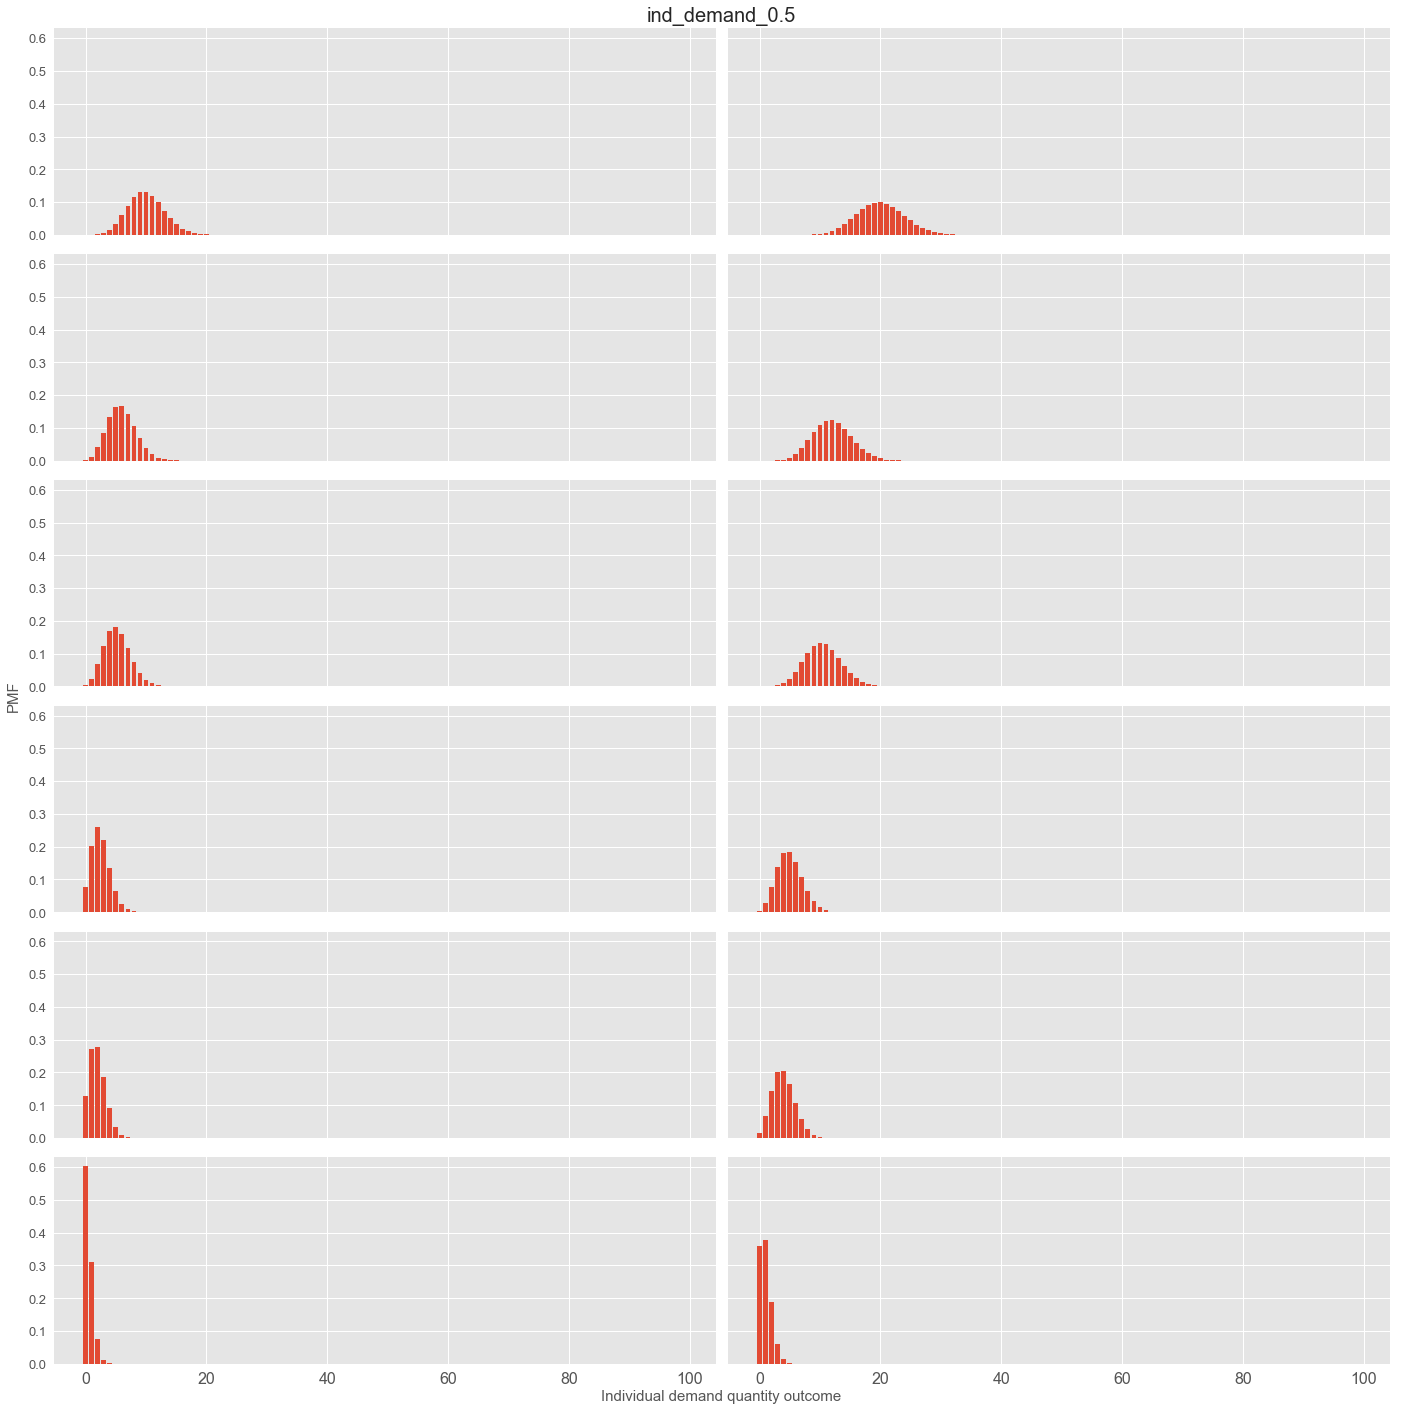

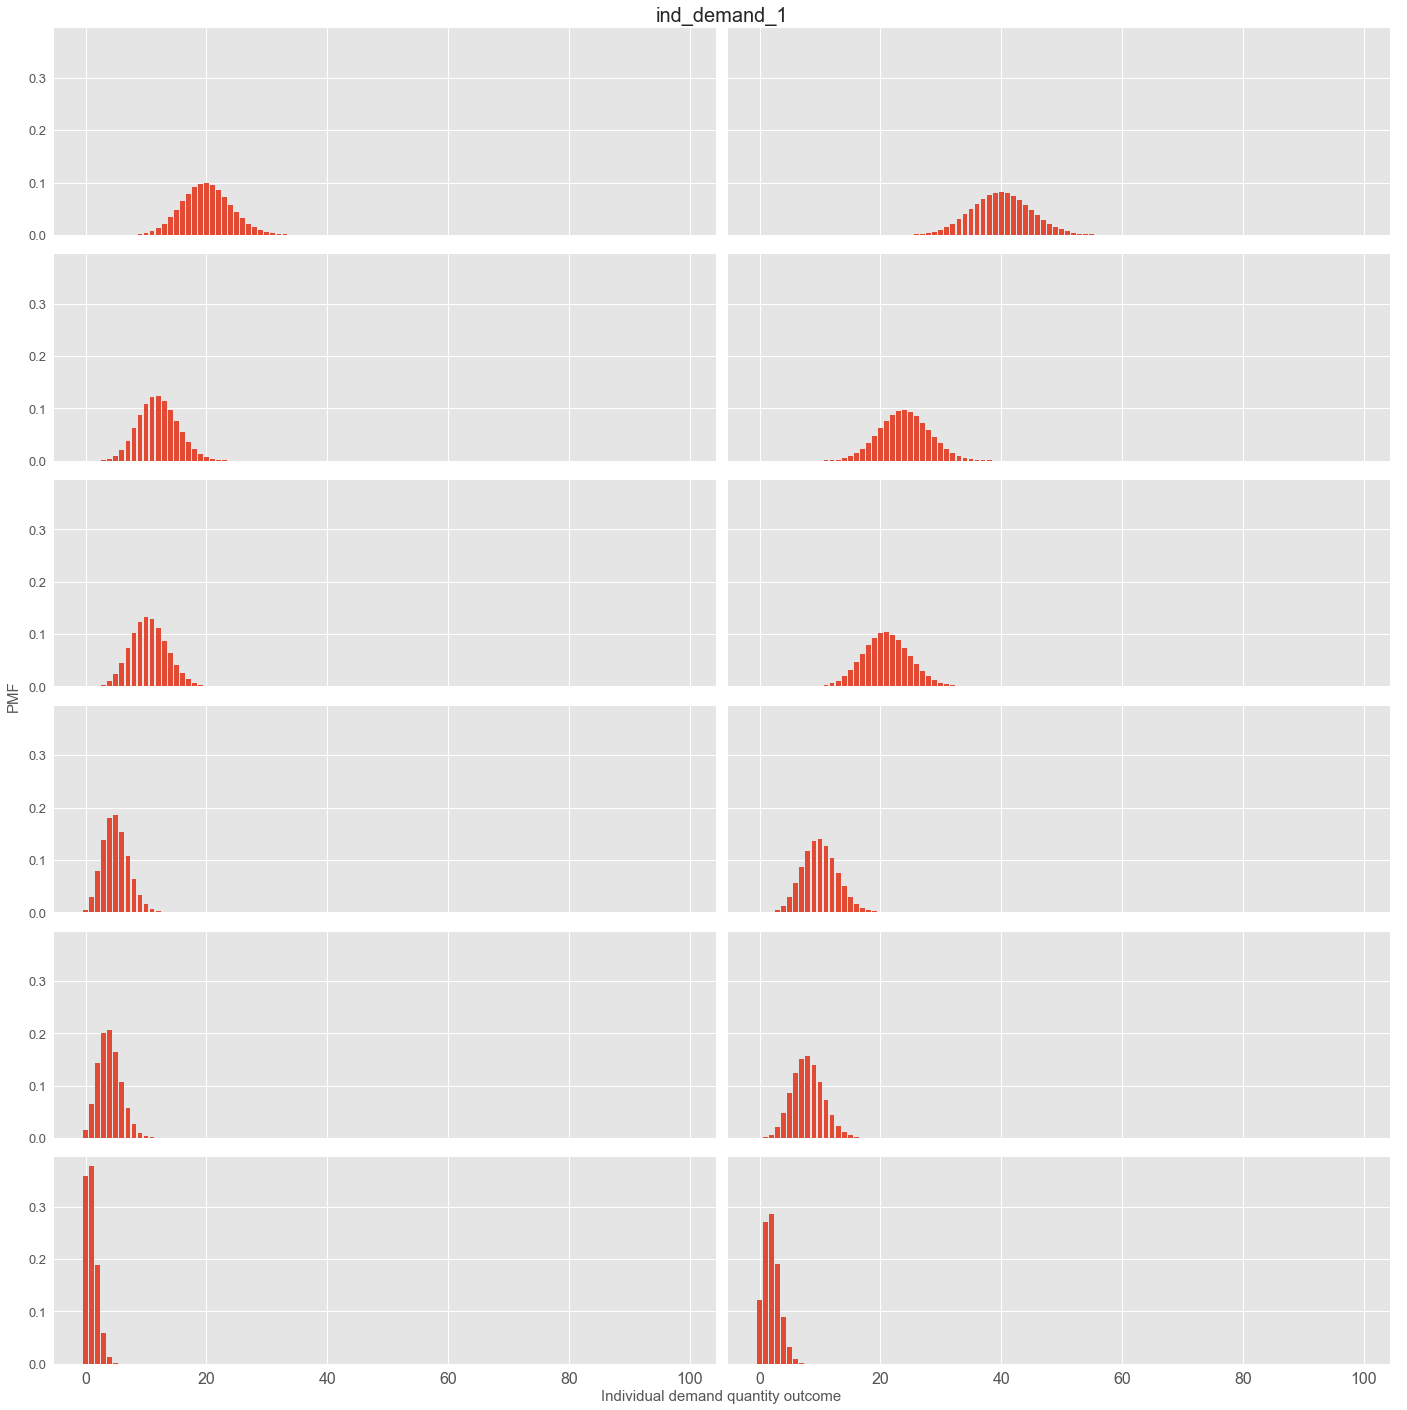

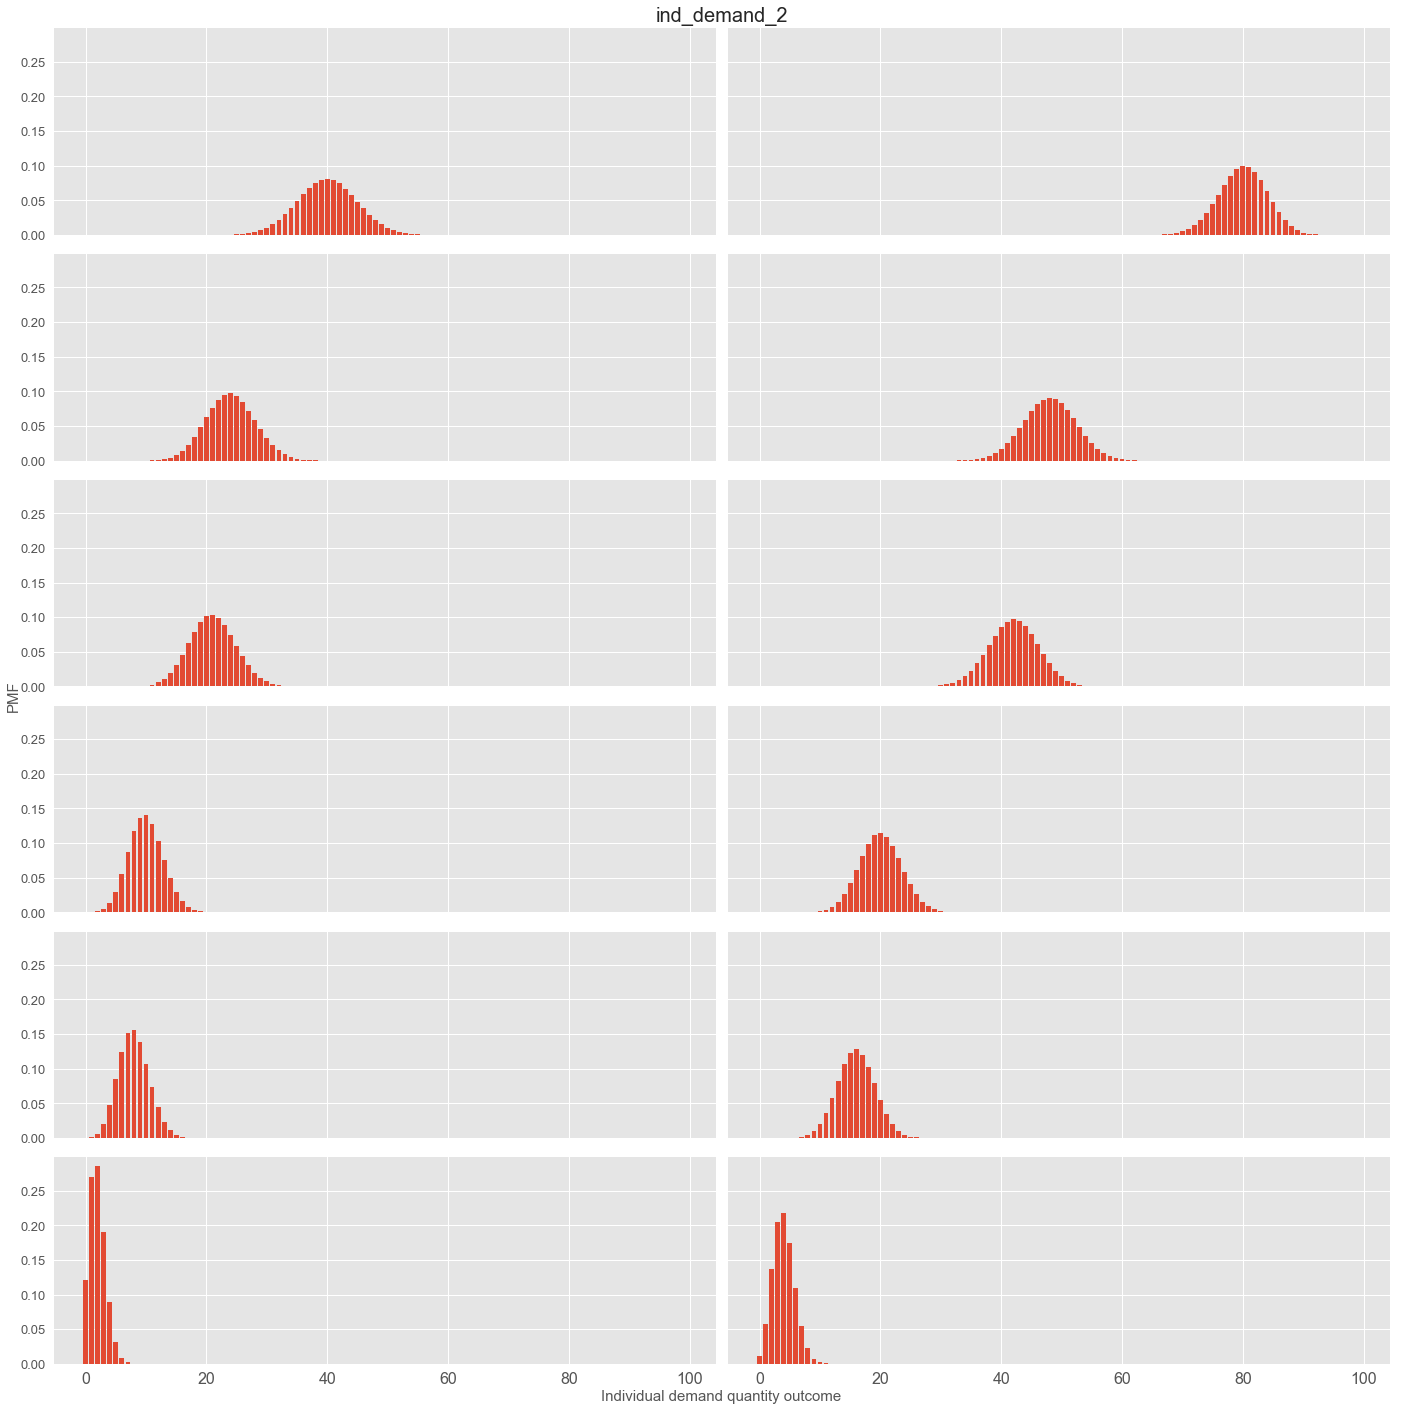

In [173]:
for ind_factor in scenarios["individual"]:
    plot_pmf(ind_factor, demand_ub)

# 旅行社訂單

In [116]:
import pandas as pd
import seaborn as sns

from data_reader import CSVDataReader
from os.path import join


# from plotter import plot_heatmap
# from validator import Validator, ConstraintViolation

In [117]:
import numpy as np
import pandas as pd

from data_reader import CSVDataReader


class ConstraintViolation(Exception):
    def __init__(self, scenario, instance_id, hint=None, *args: object) -> None:
        self.scenario = scenario
        self.instance_id = instance_id
        self.hint = hint
        super().__init__(*args)
    
    def __str__(self):
        return f"{self.hint}| Scenario: {self.scenario}| \
                 Instance: {self.instance_id}"

class Validator:
    def __init__(self, scenario, instance_id: int, acceptance: np.array, 
                 upgrade: np.array, sale: pd.DataFrame):
        """
        Methods
        --------
        `validate_shape`
        `validate_capacity_obj`
        `validate_obj`
        """
        self.scenario = scenario
        self.instance_id = instance_id
        self.acceptance = acceptance
        self.upgrade = upgrade
        reader = CSVDataReader(scenario)
        self.order_price, self.order_room, self.order_stay = \
            reader.collect_agent_info(instance_id)
        self.capacity, self.upgrade_fee = reader.collect_hotel_info(instance_id)
        self.ind_pmf, self.ind_room_price, self.demand_ub = \
            reader.collect_individual_info()
        self.error_base = ConstraintViolation(self.scenario, self.instance_id)
        self.num_room = self.capacity.shape[0]
        self.num_order = self.order_price.shape[0]
        self.num_period = self.order_stay.shape[1]
        self.sale = sale
        
    def validate_shape(self):
        if not (self.num_order == self.acceptance.shape[0]):
            self.error_base.hint = "Acceptance length not order length"
            raise self.error_base

        if not (
            (self.upgrade.shape[1] == self.upgrade.shape[2]) &
            (self.upgrade.shape[1] == self.num_room) &
            (self.upgrade.shape[0] == self.num_order)
        ):
            self.error_base.hint = "Upgrade shape error"
            raise self.error_base

        if (self.upgrade.sum(axis=0).diagonal() != 0).any():
            self.error_base.hint = "Nonzero in diagonal of upgrade"
            raise self.error_base

        if (np.tril(self.upgrade) > 0).any():
            self.error_base.hint = "Nonzero in lower triangle of upgrade"
            raise self.error_base

    def _validate_capacity(self):
        
        upgrade_diff = (
            np.dot(self.upgrade, -np.ones((self.num_room, 1))).reshape(
                (self.num_order, self.num_room)
            ) +
            np.dot(np.ones(self.num_room), self.upgrade).reshape(
                (self.num_order, self.num_room)
            )
        )
        final_demand = np.dot(
            (self.order_room + upgrade_diff).T, 
            self.acceptance.reshape((self.num_order, 1)) * self.order_stay
        )
        if (final_demand > 
            np.repeat(
                np.reshape(self.capacity, (self.num_room, 1)), 
                self.num_period,
                axis=1
            )).any():
            self.error_base.hint = "Demand exceeds capacity"
            raise self.error_base
        self.vacancy = (self.capacity.reshape((self.num_room, 1)) * 
                        np.ones(self.num_period))
        self.vacancy = self.vacancy - final_demand
        self.agent_demand = final_demand

    def validate_capacity_obj(self, obj):
        self._validate_capacity()
        
        agent_rev = np.dot(
            self.acceptance, 
            self.order_price.reshape((self.num_order, 1))
        )[0]
        upgrade_rev = (
            self.upgrade * 
            self.upgrade_fee * 
            self.order_stay.sum(axis=1).reshape(self.num_order, 1, 1)
        )
        agent_rev = agent_rev + upgrade_rev.sum()

        vacancy = self.vacancy.reshape((self.num_room, self.num_period, 1))
        vacancy = vacancy.repeat(self.ind_pmf.shape[2], 2).reshape(
            (self.num_room, self.num_period, self.ind_pmf.shape[2], 1)
        )
        ind_quantity = np.resize(np.arange(self.ind_pmf.shape[2]),
            (self.num_room, self.num_period, self.ind_pmf.shape[2], 1)
        )
        # For the calculation convenience, the matrix has the same max demand_ub 
        # elements for the last dimension. However, the PMF would be zero, so 
        # the product result should be guaranteed.
        sale = np.amin(np.concatenate([vacancy, ind_quantity], axis=3), axis=3)
        mul_index = pd.MultiIndex.from_product(
            [[str(r + 1) for r in range(self.num_room)], 
             [str(t + 1) for t in range(self.num_period)],
             [str(o + 1) for o in range(self.ind_pmf.shape[2])]],
            names=["room", "time", "outcome"]
        )
        sale_df = pd.DataFrame(sale.flatten(), index=mul_index, columns=["sale"])
        sale_merge = sale_df.merge(self.sale, left_index=True, right_index=True, 
                                suffixes=['_validator', '_gurobi'], how='left', 
                                indicator=True)
        # sale_merge.to_csv("merge.csv")
        sale_gurobi = sale_merge['sale_gurobi'].fillna(0).to_numpy().reshape(
            (self.num_room, self.num_period, self.ind_pmf.shape[2])
        )

        ind_rev = (sale * self.ind_pmf * 
                   self.ind_room_price.reshape((self.num_room, 1, 1)))
        total_exp_rev = agent_rev + ind_rev.sum()

        if not np.isclose(
            (sale_gurobi * self.ind_pmf * 
             self.ind_room_price.reshape((self.num_room, 1, 1))).sum(), 
            ind_rev.sum(), 
            rtol=0, 
            atol=1
        ):
            # TODO would test with any or all not the sum product 
            # to more thoroughly
            # FIXME magic number around np.isclose
            self.error_base.hint = "Effective sale not match"
            raise self.error_base

        if not np.isclose(total_exp_rev, obj, rtol=0, atol=1):
            # FIXME magic number around np.isclose
            self.error_base.hint = "Obj error"
            raise self.error_base 
        



In [268]:
class SolutionManager:
    def __init__(self, scenario, solution_root):
        agent_demand = []
        upgrade_list = []
        for instance_id in range(5):
            reader = CSVDataReader(scenario)
            order_price, order_room, order_stay = \
                reader.collect_agent_info(instance_id)
            capacity, upgrade_fee = reader.collect_hotel_info(instance_id)
            ind_pmf, ind_room_price, demand_ub = \
                reader.collect_individual_info()
            num_room = capacity.shape[0]
            num_order = order_price.shape[0]
            num_period = order_stay.shape[1]
            solution_folder = join(
                solution_root, 
                f"{scenario['agent']}{scenario['individual']}"
            )
            acceptance = pd.read_csv(join(solution_folder, f'{instance_id}_acceptance.csv'))
            acceptance = acceptance.to_numpy().flatten()
            upgrade = xr.open_dataset(join(solution_folder, f"{instance_id}_upgrade.nc"))
            upgrade = upgrade.to_array()[0].values
            sum_upgrade = upgrade.sum(axis=0)
            sale = pd.read_csv(join(solution_folder, f"{instance_id}_sale.csv"))
            sale['room'] = sale.room.astype('str')
            sale['time'] = sale.time.astype('str') 
            sale['outcome'] = sale.outcome.astype('str')
            sale = sale.set_index(['room', 'time', 'outcome'])

            test = Validator(scenario, instance_id, acceptance, upgrade, sale)
            room_demand = test.order_room.sum(axis=0).reshape((-1, 1))
            upgrade_ratio = sum_upgrade / room_demand
            try:
                test.validate_shape()
            except ConstraintViolation as e:
                if e.hint == "Nonzero in lower triangle of upgrade":
                    pass
                else:
                    raise e
            try:
                test.validate_capacity_obj(obj=0)
            except ConstraintViolation as e:
                if e.hint == "Obj error":
                    pass
                else:
                    raise e
            agent_demand.append(test.agent_demand)
            upgrade_list.append(upgrade_ratio)
            self.capacity = capacity
        self.agent_demand = np.array(agent_demand)
        self.mean_upgrade = np.mean(upgrade_list, axis=0)
        
        
    def plot_agent_demand(self, file_name):
        df = self.agent_demand.mean(axis=0)
        base = np.repeat(
            np.reshape(self.capacity, (self.capacity.shape[0], 1)), 
            self.agent_demand.shape[-1],
            axis=1
        )
        df = df / base
        plot_heatmap(df, x_tick=np.arange(df.shape[1]) + 1, 
                     y_tick=np.arange(df.shape[0]) + 1, 
                     x_label="Room type", y_label="Time period", 
                     title="Demand quantity from agents", 
                     file_name=file_name, figsize=(20, 8), 
                     vmin=0, vmax=1)
        
    def save_upgrade(self, file_name):
        pd.DataFrame(self.mean_upgrade, columns=[f"Room{i}" for i in np.arange(1, 7)], index=[f"Room{i}" for i in np.arange(1, 7)]).to_csv(file_name)
        

        

In [199]:
def plot_heatmap(df, x_tick, y_tick, x_label, y_label, title, file_name, figsize, vmin=None, vmax=None):
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(df, square=False, annot=True, cbar=False, fmt='.2f', cmap="Blues", vmin=vmin, vmax=vmax)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    # ax.set_xticks(np.arange(len(x_tick)) + 0.5)
    # ax.set_yticks(np.arange(len(y_tick)) + 0.5)
    ax.xaxis.set_ticklabels(x_tick)
    ax.yaxis.set_ticklabels(y_tick, rotation=45, va="center")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(file_name)
    plt.close()

In [269]:
for rule in ['up', 'down', 'both']:
    for agent_factor in scenarios["agent"]:
        for ind_factor in scenarios["individual"]:
            s = {"agent": agent_factor, "individual": ind_factor}
            try:
                sol_manager = SolutionManager(s, f'{rule}_solution')
            except ConstraintViolation as e:
                print(rule, e)
#             sol_manager.plot_agent_demand(file_name=f"{rule}/{s['agent']}_{s['individual']}__agent_demand.png")
            sol_manager.save_upgrade(file_name=f"{rule}/upgrade__{s['agent']}_{s['individual']}.csv")

up Demand exceeds capacity| Scenario: {'agent': 'stay_mul_0.250_high_request_room_id_0', 'individual': 'ind_demand_0.5'}|                  Instance: 1
up Demand exceeds capacity| Scenario: {'agent': 'stay_mul_0.250_high_request_room_id_5', 'individual': 'ind_demand_1'}|                  Instance: 3
up Demand exceeds capacity| Scenario: {'agent': 'stay_mul_0.200_high_request_room_id_0', 'individual': 'ind_demand_0.5'}|                  Instance: 0
up Demand exceeds capacity| Scenario: {'agent': 'stay_mul_0.200_high_request_room_id_0', 'individual': 'ind_demand_2'}|                  Instance: 3
up Demand exceeds capacity| Scenario: {'agent': 'stay_mul_0.143_high_request_room_id_2', 'individual': 'ind_demand_0.5'}|                  Instance: 0
up Demand exceeds capacity| Scenario: {'agent': 'stay_mul_0.143_high_request_room_id_2', 'individual': 'ind_demand_1'}|                  Instance: 0
up Demand exceeds capacity| Scenario: {'agent': 'stay_mul_0.143_high_request_room_id_0', 'individual

In [205]:
sol_manager = SolutionManager(s, f'{rule}_solution')

In [223]:
sol_manager.mean_upgrade

array([[  0. ,  51.6,  11.6,  10.8,  13.6,   2.4],
       [203.6,   0. ,  46.8,  20.4,  20.2,  30.8],
       [304.8, 207.4,   0. ,  45.6,  43.2,  78.4],
       [328. , 279.6, 149.6,   0. , 152.2,  30.6],
       [384.8, 315.8, 184. , 140.2,   0. , 190.4],
       [402.6, 247. , 138.8, 290.2, 198.6,   0. ]])

In [ ]:
df = sol_manager.mean_upgrade

In [230]:
df = pd.DataFrame(columns=['antecedent', 'consequent', 'support', 'confidence', 'lift'])
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        if i == j:
            continue
        row = {"antecedent": f"Room {i + 1}", "consequent": f"Room {j + 1}"}
        row['support'] = data[i, j] + data[j, i]
        row['confidence'] = row['support'] / (data[i].sum())
        row['lift'] = row['confidence'] / (data[:, j].sum())
        df = df.append(row, ignore_index=True)

In [231]:
df

,antecedent,consequent,support,confidence,lift
0,Room 1,Room 2,255.2,2.835556,0.002575
1,Room 1,Room 3,316.4,3.515556,0.006623
2,Room 1,Room 4,338.8,3.764444,0.007422
3,Room 1,Room 5,398.4,4.426667,0.010348
4,Room 1,Room 6,405.0,4.500000,0.013530
5,Room 2,Room 1,255.2,0.793039,0.000488
6,Room 2,Room 3,254.2,0.789932,0.001488
7,Room 2,Room 4,300.0,0.932256,0.001838
8,Room 2,Room 5,336.0,1.044127,0.002441
9,Room 2,Room 6,277.8,0.863269,0.002596


In [233]:
import networkx as nx
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
from itertools import combinations
from pyvis.network import Network

In [255]:


net = Network(notebook=True)
nodes = {}
edge_info = []
for i, relation in df.iterrows():
    for room in [relation['antecedent'], relation['consequent']]:
        if room in nodes:
            nodes[room] += relation['lift']
        else:
            nodes[room] = relation['lift']
    edge_info.append([relation['antecedent'], relation['consequent'], relation['lift']])

In [256]:
[i[0] + "'s" for i in nodes.items()]

["Room 1's", "Room 2's", "Room 3's", "Room 4's", "Room 5's", "Room 6's"]

In [258]:
net = Network(notebook=True, width="800px", height="800px")
# G = nx.DiGraph()
net.add_nodes([i[0] for i in nodes.items()], value=[i[1] for i in nodes.items()], title=[i[0] for i in nodes.items()])

for link in edge_info:
    net.add_edge(link[0], link[1], value=link[2], title=link[2])
    
# pos = nx.spring_layout(G)

# node_sizes = [i[1] for i in nodes.items()]
# M = G.number_of_edges()
# edge_colors = range(2, M + 2)
# edge_alphas = [(5 + i) / (M + 4) for i in range(M)]
# cmap = plt.cm.plasma

# nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="indigo")
# edges = nx.draw_networkx_edges(
#     G,
#     pos,
#     node_size=node_sizes,
#     arrowstyle="->",
#     arrowsize=10,
#     edge_color=edge_colors,
#     edge_cmap=cmap,
#     width=2,
# )
# # set alpha value for each edge
# for i in range(M):
#     edges[i].set_alpha(edge_alphas[i])

# pc = mpl.collections.PatchCollection(edges, cmap=cmap)
# pc.set_array(edge_colors)
# plt.colorbar(pc)

# ax = plt.gca()
# ax.set_axis_off()
# plt.show()
# neighbor_map = net.get_adj_list()

# add neighbor data to node hover data
# for node in net.nodes:
#     node['title'] += ' Neighbors:<br>' + '<br>'.join(neighbor_map[node['id']])
    # node['value'] = len(neighbor_map[node['id']])

# net.set_options("""var options = {
#   "edges": {
#     "color": {
#       "inherit": true
#     },
#     "smooth": false
#   },
#   "interaction": {
#     "hover": true,
#     "multiselect": true
#   },
#   "physics": {
#      "barnesHut": {
#       "gravitationalConstant": -28260,
#       "damping": 0.63
#     },
#     "maxVelocity": 49,
#     "minVelocity": 0.74
#   }
# }""")


net.show("network.html")

In [260]:
edge_info

[['Room 1', 'Room 2', 0.0025745011399632787],
 ['Room 1', 'Room 3', 0.006623126517625388],
 ['Room 1', 'Room 4', 0.007422011917280057],
 ['Room 1', 'Room 5', 0.010347514414835595],
 ['Room 1', 'Room 6', 0.013529765484064942],
 ['Room 2', 'Room 1', 0.0004883847485863443],
 ['Room 2', 'Room 3', 0.0014881907207151936],
 ['Room 2', 'Room 4', 0.0018380442816726891],
 ['Room 2', 'Room 5', 0.0024406890762602024],
 ['Room 2', 'Room 6', 0.00259551747218648],
 ['Room 3', 'Room 1', 0.00028679950354317034],
 ['Room 3', 'Room 2', 0.00033970734065600874],
 ['Room 3', 'Room 4', 0.0005664675363026755],
 ['Room 3', 'Room 5', 0.0007817034060386313],
 ['Room 3', 'Room 6', 0.0009611961741205982],
 ['Room 4', 'Room 1', 0.00022196423938594255],
 ['Room 4', 'Room 2', 0.0002897666026604437],
 ['Room 4', 'Room 3', 0.00039121999711395076],
 ['Room 4', 'Room 5', 0.0007271244268051286],
 ['Room 4', 'Room 6', 0.0010260871790279038],
 ['Room 5', 'Room 1', 0.0002019012612017698],
 ['Room 5', 'Room 2', 0.000251042033